In [1]:
import numpy as np
import pandas as pd
from datetime import datetime


In [20]:
df = pd.read_csv('../data/demand_lower_48')

In [21]:
df.head()

,Time,Megawatthours
0,03/21/21 20:00 -0400,390453
1,03/21/21 19:00 -0400,379932
2,03/21/21 18:00 -0400,371950
3,03/21/21 17:00 -0400,365016
4,03/21/21 16:00 -0400,363364


In [22]:
df['Time'] = df['Time'].apply(lambda x: x[:-6])

In [23]:
df.head()

,Time,Megawatthours
0,03/21/21 20:00,390453
1,03/21/21 19:00,379932
2,03/21/21 18:00,371950
3,03/21/21 17:00,365016
4,03/21/21 16:00,363364


In [24]:
df['Time'] = pd.to_datetime(df['Time'])

In [25]:
df.head()

,Time,Megawatthours
0,2021-03-21 20:00:00,390453
1,2021-03-21 19:00:00,379932
2,2021-03-21 18:00:00,371950
3,2021-03-21 17:00:00,365016
4,2021-03-21 16:00:00,363364


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50180 entries, 0 to 50179
Data columns (total 2 columns):
Time             50180 non-null datetime64[ns]
Megawatthours    50180 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 784.1 KB


In [27]:
df = (df.loc[::-1]).reset_index(drop=True)

In [28]:
df.head()

,Time,Megawatthours
0,2015-07-01 01:00:00,162827
1,2015-07-01 02:00:00,335153
2,2015-07-01 03:00:00,333837
3,2015-07-01 04:00:00,398386
4,2015-07-01 05:00:00,388954


In [29]:
df = df[1:]

In [30]:
def create_X_y(time_series, lag=3):
    X, y = [], []
    if len(time_series) - lag <= 0:
        X.append(time_series)
    else:
        for i in range(len(time_series) - lag):
            y.append(time_series[i + lag])
            X.append(time_series[i:(i + lag)])
            
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y

In [31]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [32]:
n_layer = 50
n_lag = 3

In [33]:
model = Sequential()

In [34]:
model.add(LSTM(n_layer, activation='relu', input_shape=(n_lag, 1)))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(optimizer='adam', loss='mse')

In [36]:
class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()

        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(self.lag, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False
        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat

In [41]:
deep_learner = DeepModelTS(data = df, 
                          Y_var = 'Megawatthours',
                          lag=24, 
                          LSTM_layer_depth=50,
                          epochs=50, 
                          batch_size=256,
                          train_test_split=0.15)

In [42]:
model = deep_learner.LSTModel()

Epoch 1/50
167/167 [==============================] - 2s 11ms/step - loss: 285014065152.0000 - val_loss: 54823739392.0000
Epoch 2/50
167/167 [==============================] - 2s 11ms/step - loss: 19160418304.0000 - val_loss: 5968010240.0000
Epoch 3/50
167/167 [==============================] - 2s 11ms/step - loss: 4263261696.0000 - val_loss: 4489943040.0000
Epoch 4/50
167/167 [==============================] - 2s 11ms/step - loss: 4552672256.0000 - val_loss: 5931709440.0000
Epoch 5/50
167/167 [==============================] - 2s 11ms/step - loss: 4024715776.0000 - val_loss: 4476173312.0000
Epoch 6/50
167/167 [==============================] - 2s 11ms/step - loss: 4993641472.0000 - val_loss: 3518490112.0000
Epoch 7/50
167/167 [==============================] - 2s 11ms/step - loss: 3333946368.0000 - val_loss: 3407474688.0000
Epoch 8/50
167/167 [==============================] - 2s 11ms/step - loss: 3198673920.0000 - val_loss: 3280867328.0000
Epoch 9/50
167/167 [========================

In [44]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

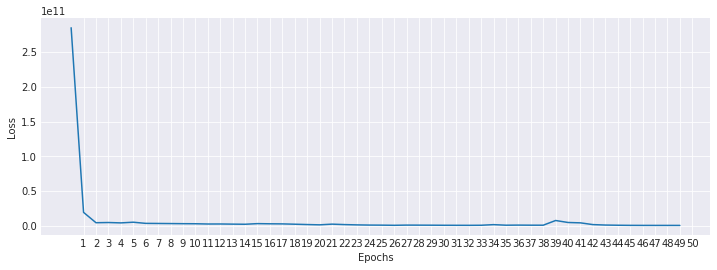

In [46]:
losses_lstm = model.history.history['loss']
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_xticks(np.arange(1,51))
ax.plot(range(len(losses_lstm)), losses_lstm);

In [47]:
yhat = deep_learner.predict()

In [48]:
yhat

[378615.44,
 390767.97,
 402439.66,
 412264.3,
 420078.3,
 426124.4,
 430667.56,
 432954.88,
 432577.44,
 429405.8,
 425671.44,
 418382.38,
 408640.2,
 395877.3,
 383077.75,
 371195.4,
 360574.44,
 351984.75,
 346553.5,
 345288.38,
 347954.56,
 353173.94,
 359908.8,
 368086.34,
 377620.1,
 387499.72,
 397193.84,
 405649.25,
 412761.34,
 418791.53,
 423527.0,
 426262.28,
 426846.38,
 425301.62,
 423465.2,
 418108.66,
 410109.44,
 397995.6,
 384969.28,
 372271.72,
 360866.03,
 351303.0,
 344668.8,
 342191.97,
 343912.47,
 348678.12,
 355387.03,
 364030.6,
 374032.03,
 385148.53,
 397366.4,
 408907.3,
 419023.16,
 427623.75,
 434834.0,
 439861.22,
 441812.12,
 440781.9,
 438538.3,
 432017.12,
 420954.88,
 407691.5,
 392641.4,
 377879.3,
 364360.0,
 352916.25,
 344767.75,
 340779.88,
 341225.94,
 345577.44,
 352832.12,
 362936.78,
 375243.34,
 389222.75,
 404172.1,
 418824.38,
 431860.6,
 443121.7,
 451795.25,
 457141.84,
 458631.94,
 456080.8,
 451519.7,
 442144.78,
 428552.94,
 413067.56

In [50]:
forecast = df.tail(len(yhat)).copy()
forecast.reset_index(inplace=True)
forecast['lstm_forecast'] = yhat

In [51]:
forecast.head()

,index,Time,Megawatthours,lstm_forecast
0,42657,2020-05-12 10:00:00,389687,378615.43750
1,42658,2020-05-12 11:00:00,396999,390767.96875
2,42659,2020-05-12 12:00:00,403868,402439.65625
3,42660,2020-05-12 13:00:00,407703,412264.31250
4,42661,2020-05-12 14:00:00,410129,420078.31250


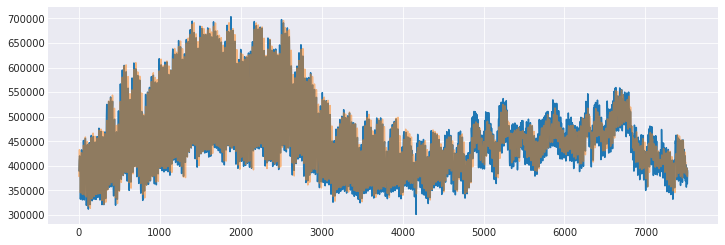

In [54]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(yhat)), forecast['Megawatthours'])
ax.plot(range(len(yhat)), forecast['lstm_forecast'], alpha=.5)
plt.show()

In [55]:
forecast.tail()

,index,Time,Megawatthours,lstm_forecast
7518,50175,2021-03-21 16:00:00,363364,378925.96875
7519,50176,2021-03-21 17:00:00,365016,378271.90625
7520,50177,2021-03-21 18:00:00,371950,379545.18750
7521,50178,2021-03-21 19:00:00,379932,383010.40625
7522,50179,2021-03-21 20:00:00,390453,386552.81250
